In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import nibabel
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from torch.utils.data import random_split


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Selecting only the regions needed in for our detection

- left cerebral white matter = 2
- left hippocampus = 17
- right cerebral white matter = 41
- right hippocampus = 53

In [2]:
def apply_mask(aseg_image, brain_image, labels = [17, 53, 2, 41]):
    from scipy.ndimage import zoom
    brain_data = brain_image.get_fdata() 
    aseg_data = aseg_image.get_fdata() 
    brain_mask = np.zeros_like(aseg_data)
    for label in labels:
        brain_mask += np.where((aseg_data == label), 1, 0)

    segmented_brain_image = brain_data * brain_mask #applied mask on the brain image
#     resized_image = zoom(segmented_brain_image, np.array(target_size) / np.array(segmented_brain_image.shape), order=0)
    segmented_brain_image = nibabel.Nifti1Image(segmented_brain_image, affine=None) # Generating the nii image
    
    return segmented_brain_image

def resize_image(img_data):
    resized_img_data = torch.nn.functional.interpolate(
        torch.unsqueeze(torch.unsqueeze(torch.tensor(img_data), 0), 0),
        size=(100, 100, 100),
        mode='trilinear',
        align_corners=False,
    )
    return resized_img_data.squeeze().numpy()

In [3]:
csv_path = "/kaggle/input/adni-1-5t-fastsurfer-quickseg/ADNI-1.5T-FastSurfer-QuickSeg/ADNI1_Screening_1.5T_1_29_2024.csv"
base = "/kaggle/input/adni-1-5t-fastsurfer-quickseg/ADNI-1.5T-FastSurfer-QuickSeg/"
mri_images = os.listdir(os.path.join(base, "AD"))
for i in os.listdir(os.path.join(base, "CN")):
    mri_images.append(i)
for i in os.listdir(os.path.join(base, "MCI")):
    mri_images.append(i)
    
csv_data = pd.read_csv(csv_path)
df = pd.DataFrame(csv_data)

In [4]:
for index, row in df.iterrows():
    file_name = row['Image Data ID'] + ".nii"
    if file_name not in mri_images:
        df = df.drop(index)
df.to_csv("filter_csv.csv")
csv_path = "/kaggle/working/filter.csv"

In [5]:
len(df), len(mri_images)

(982, 982)

In [6]:
df.head(20)

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
0,I62666,013_S_1275,MCI,F,79,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,2/22/2007,NiFTI,1/29/2024
1,I119268,121_S_1322,MCI,F,72,sc,MRI,MPR; ; N3; Scaled_2,Processed,3/02/2007,NiFTI,1/29/2024
2,I59697,116_S_0649,MCI,M,87,sc,MRI,MPR; GradWarp; N3; Scaled,Processed,7/24/2006,NiFTI,1/29/2024
3,I68581,099_S_0880,MCI,M,84,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,10/05/2006,NiFTI,1/29/2024
4,I60760,029_S_1318,MCI,F,83,sc,MRI,MPR-R; GradWarp; B1 Correction; N3; Scaled,Processed,2/17/2007,NiFTI,1/29/2024
5,I62656,013_S_1186,MCI,M,83,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,1/29/2007,NiFTI,1/29/2024
6,I119369,128_S_0188,MCI,M,86,sc,MRI,MPR-R; GradWarp; N3; Scaled_2,Processed,2/06/2006,NiFTI,1/29/2024
7,I31509,023_S_0855,MCI,M,76,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,9/05/2006,NiFTI,1/29/2024
8,I63135,073_S_1357,MCI,M,71,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,4/09/2007,NiFTI,1/29/2024
9,I39152,130_S_0783,MCI,F,79,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,8/17/2006,NiFTI,1/29/2024


# Defining MobileNetV2 architecture

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Inverted Residual Block for 3D MobileNetV2
class InvertedResidual(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        self.use_res_connect = self.stride == 1 and in_channels == out_channels
        
        # Expanding the input channels by the expansion ratio
        hidden_channels = int(in_channels * expand_ratio)
        
        layers = []
        
        # 1x1x1 Convolution for expanding the channels
        layers.append(nn.Conv3d(in_channels, hidden_channels, kernel_size=1, stride=1, padding=0, bias=False))
        layers.append(nn.BatchNorm3d(hidden_channels))
        layers.append(nn.ReLU6(inplace=True))
        
        # 3x3x3 Depthwise Separable Convolution (depthwise)
        layers.append(nn.Conv3d(hidden_channels, hidden_channels, kernel_size=3, stride=stride, padding=1, groups=hidden_channels, bias=False))
        layers.append(nn.BatchNorm3d(hidden_channels))
        layers.append(nn.ReLU6(inplace=True))
        
        # 1x1x1 Convolution for projecting back to output channels
        layers.append(nn.Conv3d(hidden_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False))
        layers.append(nn.BatchNorm3d(out_channels))
        
        self.block = nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.block(x)
        if self.use_res_connect:
            return out + x
        else:
            return out

# 3D MobileNetV2 Model
class MobileNetV2(nn.Module):
    def __init__(self, num_classes=1000):
        super(MobileNetV2, self).__init__()
        
        # Initial Conv Layer for 3D inputs
        self.conv1 = nn.Conv3d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(32)
        self.relu = nn.ReLU6(inplace=True)
        
        # Defining the layers in the network
        self.layers = self._make_layers()
        
        # Final classifier layer
        self.conv2 = nn.Conv3d(320, num_classes, kernel_size=1, stride=1, padding=0)
    
    def _make_layers(self):
        # MobileNetV2 configuration for inverted residual blocks
        config = [
            # in_channels, out_channels, stride, expand_ratio
            (32, 16, 1, 1),
            (16, 24, 2, 6),
            (24, 24, 1, 6),
            (24, 32, 2, 6),
            (32, 32, 1, 6),
            (32, 64, 2, 6),
            (64, 64, 1, 6),
            (64, 96, 1, 6),
            (96, 160, 2, 6),
            (160, 160, 1, 6),
            (160, 320, 1, 6),
        ]
        
        layers = []
        in_channels = 32
        
        # Create all layers based on the configuration
        for t, c, s, e in config:
            layers.append(InvertedResidual(in_channels, c, s, e))
            in_channels = c
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.layers(x)
        
        x = self.conv2(x)
        x = F.adaptive_avg_pool3d(x, (1, 1, 1))
        x = x.view(x.size(0), -1)
        
        return x

# Instantiate the model
def mobilenet_v2_3d(num_classes=1000):
    return MobileNetV2(num_classes)

# Example usage
model = mobilenet_v2_3d(num_classes=3)  # For 3-class classification

# Sample input: batch of 8 3D images (1 channel, 100x100x100 depth)
input_tensor = torch.randn(8, 1, 100, 100, 100)
output = model(input_tensor)
print(output.shape)  # Expected output: torch.Size([8, 3])


torch.Size([8, 3])


In [8]:
class MriDataset():
    def __init__(self, csv_path,transform=None):
        self.data = pd.read_csv(csv_path)
        self.transform = transform
        self.le = LabelEncoder()  # Add this line
        self.encoded_classes = self.le.fit_transform(self.data["Group"].values)  # Add this line

    
    def __len__(self):
        return len(self.data)

    
    def _load_image(self, img_id, label):
        base = "/kaggle/input/adni-1-5t-fastsurfer-quickseg/ADNI-1.5T-FastSurfer-QuickSeg"
        img_id = img_id + ".nii"
        subject_dir = os.path.join(base, label, img_id, "mri")
        
        aseg_image = nibabel.load(os.path.join(subject_dir, "aparc.DKTatlas+aseg.deep.mgz"))
        brain_image = nibabel.load(os.path.join(subject_dir, "aparc.DKTatlas+aseg.deep.mgz"))
        
        image = apply_mask(aseg_image, brain_image) #applying the selected labels
        image = image.get_fdata()
        
        image_resized = resize_image(image) 
        image_resized = np.expand_dims(image_resized, axis=0)
        image_resized = torch.tensor(image_resized, dtype=torch.float)
        
        return image_resized
        
        
    def __getitem__(self, idx):
        img_id = self.data.iloc[idx, 1]
        label = self.data.iloc[idx, 3]
        
        img = self._load_image(img_id, label) #loading the image
        one_hot_label = np.eye(len(self.le.classes_))[self.encoded_classes[idx]]
        
        #img = np.transpose(img, (2, 0, 1))    # Transpose the image to match PyTorch's tensor format (C x H x W)
        if self.transform:
            img = self.transform(img)
        return img, one_hot_label

# Model and train dataset

In [9]:
# Define transformations
transform = transforms.Compose([
#     transforms.ToTensor(),
])

dataset = MriDataset(csv_path="/kaggle/working/filter_csv.csv", transform=transform)
train_size = int(0.7 * len(dataset))
validation_size = int(0.15 * len(dataset))
test_size = len(dataset)-(train_size + validation_size)

train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])

In [10]:
train_size, validation_size, test_size

(687, 147, 148)

In [11]:
# Load data
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True, pin_memory = True)
validation_loader = DataLoader(validation_dataset, batch_size = 20, shuffle=True, pin_memory = True)
test_loader = DataLoader(test_dataset, batch_size = 20, shuffle=True, pin_memory = True)


#model
model = mobilenet_v2_3d(num_classes=3)
# model = models.resnet18(pretrained = True)

# model.conv1 = nn.Conv2d(150, 64, kernel_size=7, stride=2, padding=3, bias=False)
# model.fc = nn.Linear(512, 3)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Saving checkpoint after finishing each epoch

In [12]:
checkpoint_dir = "/kaggle/working/checkpoint"
os.makedirs(checkpoint_dir, exist_ok=True)

# Loading saved checkpoints

In [13]:
# path = "/kaggle/input/checkpoint-1/model_epoch_10_batch_31.pt"
# checkpoint = torch.load(path)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# check_epoch = checkpoint['epoch']
# model.to(device)

# Training the model

In [14]:
num_epochs = 25  # 25 Epochs
loss_list = []
accuracy_list = []

for epoch in range(num_epochs):
    torch.cuda.empty_cache()
    
    model.train()
    total  = 0
    correct_count = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        model.to(device)
        data, target = data.to(device, dtype=torch.float), target.clone().detach().to(device)
        
        # Forward pass
        output = model(data)
        loss = criterion(output, target)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        output = output.cpu()
        target = target.cpu()
        
        correct = (torch.argmax(output, dim=1) == torch.argmax(target, dim=1)).sum().item()
        correct_count += correct
        total += len(data)
        if not (batch_idx < data.shape[0]): break 
    
    # Printing log
    accuracy = (correct_count / total) * 100
    loss_list.append(loss.item())
    accuracy_list.append(accuracy)
    
    print(f"Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}")
    
    if (epoch + 1) % 5 == 0:
        # Saving checkpoint
        checkpoint_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch+1}_batch_{batch_idx+1}.pt")
        torch.save({
                    'epoch': epoch + 1,
                    'batch_idx': batch_idx + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss.item(),
                    }, checkpoint_path)
        print(f"Checkpoint saved to {checkpoint_path}")
    
# Save final model
torch.save(model.state_dict(), "model_final.pt")


Epoch: 1/25, Loss: 1.1291, Accuracy: 40.2381
Epoch: 2/25, Loss: 1.0094, Accuracy: 55.4762
Epoch: 3/25, Loss: 1.0211, Accuracy: 64.7619
Epoch: 4/25, Loss: 0.7831, Accuracy: 69.7619
Epoch: 5/25, Loss: 1.0236, Accuracy: 76.9048
Checkpoint saved to /kaggle/working/checkpoint/model_epoch_5_batch_21.pt
Epoch: 6/25, Loss: 0.4983, Accuracy: 78.5714
Epoch: 7/25, Loss: 0.5783, Accuracy: 84.5238
Epoch: 8/25, Loss: 0.4184, Accuracy: 84.2857
Epoch: 9/25, Loss: 0.4381, Accuracy: 84.2857
Epoch: 10/25, Loss: 0.4797, Accuracy: 89.2857
Checkpoint saved to /kaggle/working/checkpoint/model_epoch_10_batch_21.pt
Epoch: 11/25, Loss: 0.3878, Accuracy: 82.8571
Epoch: 12/25, Loss: 0.5274, Accuracy: 82.6190
Epoch: 13/25, Loss: 0.2215, Accuracy: 86.9048
Epoch: 14/25, Loss: 0.4390, Accuracy: 92.6190
Epoch: 15/25, Loss: 0.4037, Accuracy: 88.5714
Checkpoint saved to /kaggle/working/checkpoint/model_epoch_15_batch_21.pt
Epoch: 16/25, Loss: 0.2720, Accuracy: 86.9048
Epoch: 17/25, Loss: 0.3302, Accuracy: 90.2381
Epoch:

Text(0.5, 1.0, 'Training Accuracy')

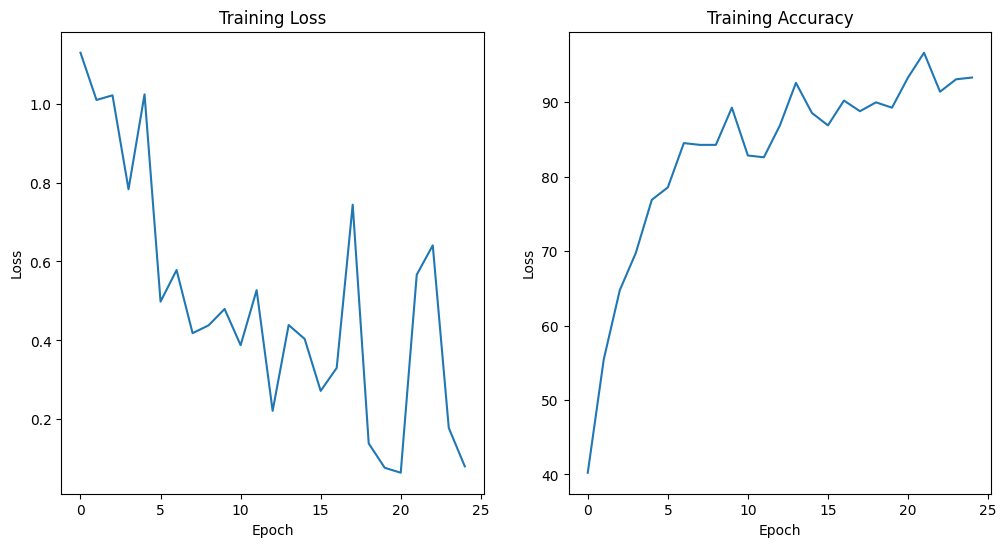

In [15]:
_, (loss_graph, accuracy_graph) = plt.subplots(1, 2, figsize=(12,6))

loss_graph.plot(loss_list)
loss_graph.set_xlabel("Epoch")
loss_graph.set_ylabel("Loss")
loss_graph.set_title("Training Loss")

accuracy_graph.plot(accuracy_list)
accuracy_graph.set_xlabel("Epoch")
accuracy_graph.set_ylabel("Loss")
accuracy_graph.set_title("Training Accuracy")

# Validation Accuracy

In [16]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for data, target in validation_loader:
        model = model.to(device)
        data, target = data.to(device, dtype = torch.float), torch.tensor(target).to(device)
        output = model(data)
        output = output.cpu()
        target = target.cpu()
        
        all_preds.extend(torch.argmax(output, dim = 1))
        all_labels.extend(torch.argmax(target, dim=1))


accuracy = accuracy_score(all_labels, all_preds)
print(f"Validation accuracy: {accuracy * 100:.2f}%")

/tmp/ipykernel_26/318942741.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = data.to(device, dtype = torch.float), torch.tensor(target).to(device)


Validation accuracy: 53.06%


# Test Accuracy

In [17]:
model.eval()
test_preds = []
test_labels = []
with torch.no_grad():
    for data, target in test_loader:
        model = model.to(device)
        data, target = data.to(device, dtype = torch.float), torch.tensor(target).to(device)
        output = model(data)
        output = output.cpu()
        target = target.cpu()
        
        test_preds.extend(torch.argmax(output, dim = 1))
        test_labels.extend(torch.argmax(target, dim=1))


accuracy = accuracy_score(all_labels, all_preds)
print(f"Test accuracy: {accuracy * 100:.2f}%")

/tmp/ipykernel_26/279744069.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = data.to(device, dtype = torch.float), torch.tensor(target).to(device)


Test accuracy: 53.06%
